In [1]:
import time
import numpy as np
import re
from glob import glob
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.preprocessing import image  
from keras.applications.resnet50 import ResNet50
from tqdm import tqdm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

In [3]:
dog_names = [item[20:-1] for item in sorted(glob("dogImages/dogImages/train/*/"))]
for index,_ in enumerate(dog_names):
    dog_names[index] = re.sub(r"train\\[0-9]+.","",dog_names[index])
dog_breeds = len(dog_names)

In [4]:
train_InceptionV3.shape[1:]

(5, 5, 2048)

In [29]:
inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
inception_model.add(Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
inception_model.add(Dropout(0.4))
inception_model.add(Dense(dog_breeds, activation='softmax'))

inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 150)               307350    
_________________________________________________________________
dropout_5 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 133)               20083     
Total params: 327,433
Trainable params: 327,433
Non-trainable params: 0
_________________________________________________________________


In [6]:
inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [7]:
inception_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

In [8]:
img_width, img_height = 224, 224

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(img_width, img_height))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [9]:
def extract_InceptionV3(tensor):
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [10]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [12]:
# top_N defines how many predictions to return
top_N = 4
global bottleneck_features
def predict_breed(path):
    
    # Timer for how long it take to predict a dog
    t0 = time.time()
    # load image using path_to_tensor
    print('Loading image...')
    image_tensor = path_to_tensor(path)
    
    # obtain bottleneck features using extract_InceptionV3
    print('Extracting bottleneck features...')
    bottleneck_features = extract_InceptionV3(image_tensor)
    
    # feed into top_model for breed prediction
    print('Feeding bottlenneck features into top model...')
    prediction = inception_model.predict(bottleneck_features)[0]
    
    # sort predicted breeds by highest probability, extract the top N predictions
    breeds_predicted = [dog_names[idx] for idx in np.argsort(prediction)[::-1][:top_N]]
    confidence_predicted = np.sort(prediction)[::-1][:top_N]
    
    # Showing the end time for prediction
    t1 = time.time()
    print("time Taken for Prediction:",t1-t0)
    print('Predicting breed...')
    # take prediction, lookup in dog_names, return value
    return breeds_predicted, confidence_predicted
    

In [13]:
def make_prediction(path, multiple_breeds = False):
    breeds, confidence = predict_breed(path)
    img = mpimg.imread(path)
    plt.axis('off')
   
    imgplot = plt.imshow(img)
    print('You look like a {}.'.format(breeds[0].replace("_", " ")))
        
        
    if multiple_breeds:
        print('\n\nTop 4 predictions (for mixed breeds)')
        for i, j in zip(breeds, confidence):
            print('Predicted breed: {} with a confidence of {:.4f}'.format(i.replace("_", " "), j))

    else:
        raise ValueError('Could not detect dogs in image.')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
time Taken for Prediction: 23.976058959960938
Predicting breed...
You look like a Beauceron.


Top 4 predictions (for mixed breeds)
Predicted breed: Beauceron with a confidence of 0.8855
Predicted breed: German shepherd dog with a confidence of 0.0544
Predicted breed: Doberman pinscher with a confidence of 0.0169
Predicted breed: Icelandic sheepdog with a confidence of 0.0112


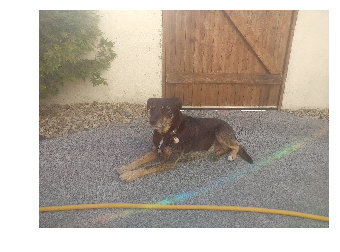

In [14]:
make_prediction('images/rolo1.jpg', multiple_breeds = True)

In [18]:
def intermediateLayer(path):
    
    # Timer for how long it take to predict a dog
    t0 = time.time()
    
    intermediate_layer_model = Model(inputs=inception_model.input, outputs=inception_model.get_layer("dense_2").output)
    
    
    # load image using path_to_tensor
    print('Loading image...')
    image_tensor = path_to_tensor(path)
    
    
    # obtain bottleneck features using extract_InceptionV3
    print('Extracting bottleneck features...')
    bottleneck_features = extract_InceptionV3(image_tensor)
    
    
    # feed into top_model for breed prediction
    print('Feeding bottlenneck features into top model...')
    #prediction = inception_model.predict(bottleneck_features)[0]
    
    intermediate_output = intermediate_layer_model.predict(bottleneck_features)

    
    # Showing the end time for prediction
    t1 = time.time()
    print("Time taken: ",t1-t0)
    return intermediate_output
#     print('Predicting breed...')
#     # take prediction, lookup in dog_names, return value
#     return breeds_predicted, confidence_predicted

In [19]:
rolo1InterLayer = np.asarray(intermediateLayer('images/rolo1.jpg'))

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Time taken:  40.6577250957489


In [20]:
jordanInterLayer = np.asarray(intermediateLayer('images/jordan.jpg'))

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Time taken:  49.70081925392151


In [21]:
rolo2InterLayer = np.asarray(intermediateLayer('images/rolo2.jpg'))

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Time taken:  54.48023200035095


In [22]:
chelseaInterLayer = np.asarray(intermediateLayer('images/chelsea.jpg'))

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Time taken:  64.21480178833008


In [23]:
testBeauceronInterLayer = np.asarray(intermediateLayer('dogImages/dogImages/test/018.Beauceron/Beauceron_01284.jpg'))

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Time taken:  92.17614006996155


In [73]:
array1 = np.asarray(matrix)
array2 = np.asarray(matrix2)

Comparison of two very differet dogs

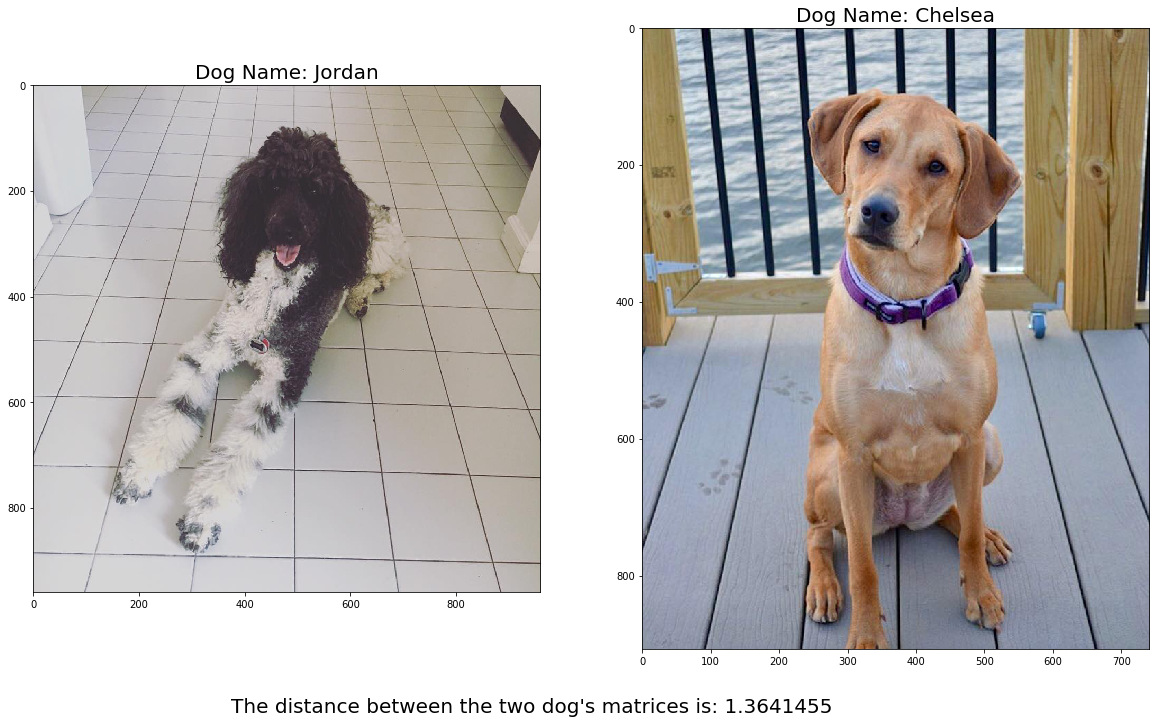

In [49]:
jordan = plt.imread('images/jordan.jpg')
chelsea = plt.imread('images/chelsea.jpg')

dist = np.linalg.norm(chelseaInterLayer - jordanInterLayer)
dist
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0),)
ax2 = plt.subplot2grid((1,2), (0,1),)
ax1.imshow(jordan)
ax1.set_title("Dog Name: Jordan",fontsize=20)
ax2.imshow(chelsea)
ax2.set_title("Dog Name: Chelsea",fontsize=20)
plt.text(-600,1000,"The distance between the two dog's matrices is: " + str(dist), fontsize=20)
plt.show()


20.172752

Compmarison of the same dog, under different lighting/sitting positions

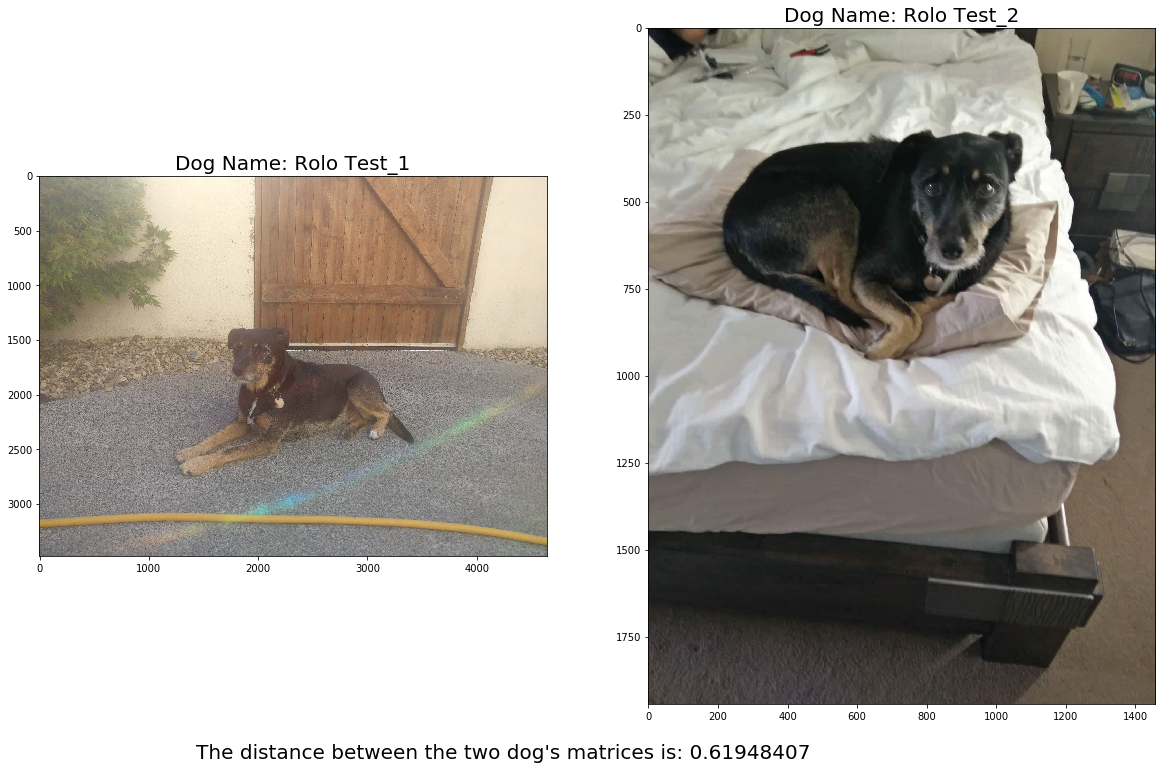

In [69]:
rolo1 = plt.imread('images/rolo1.jpg')
rolo2 = plt.imread('images/rolo2.jpg')

dist = np.linalg.norm(rolo1InterLayer-rolo2InterLayer)
dist
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0),)
ax2 = plt.subplot2grid((1,2), (0,1),)
ax1.imshow(rolo1)
ax1.set_title("Dog Name: Rolo Test_1", fontsize=20)
ax2.imshow(rolo2)
ax2.set_title("Dog Name: Rolo Test_2",fontsize=20)
plt.text(-1300,2100,"The distance between the two dog's matrices is: " + str(dist), fontsize=20)
plt.show()

In [94]:
dist = np.linalg.norm(rolo1InterLayer-rolo2InterLayer)
dist

14.59962

comparison of Rolo and Jordan

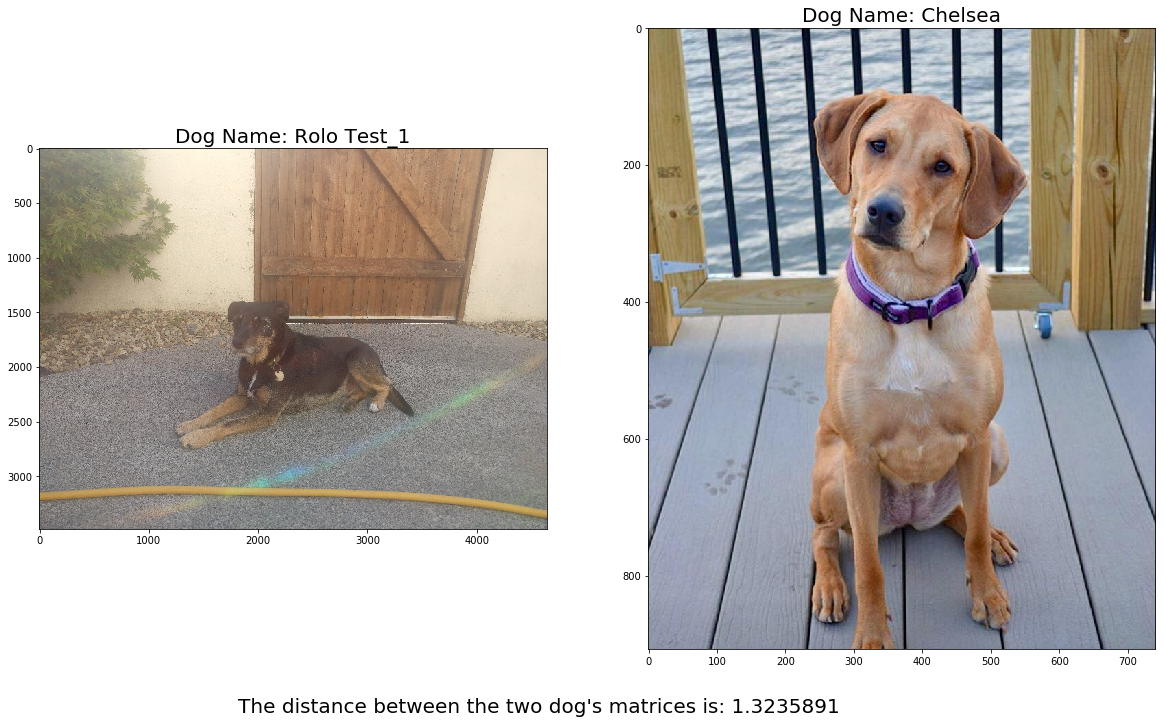

In [66]:
rolo1 = plt.imread('images/rolo1.jpg')
chelsea = plt.imread('images/chelsea.jpg')

dist = np.linalg.norm(rolo1InterLayer- jordanInterLayer)
dist
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0),)
ax2 = plt.subplot2grid((1,2), (0,1),)
ax1.imshow(rolo1)
ax1.set_title("Dog Name: Rolo Test_1", fontsize=20)
ax2.imshow(chelsea)
ax2.set_title("Dog Name: Chelsea",fontsize=20)
plt.text(-600,1000,"The distance between the two dog's matrices is: " + str(dist), fontsize=20)
plt.show()

In [90]:
dist = np.linalg.norm(rolo1InterLayer- jordanInterLayer)
dist

19.346828

Comparison of Chelsea an Rolo

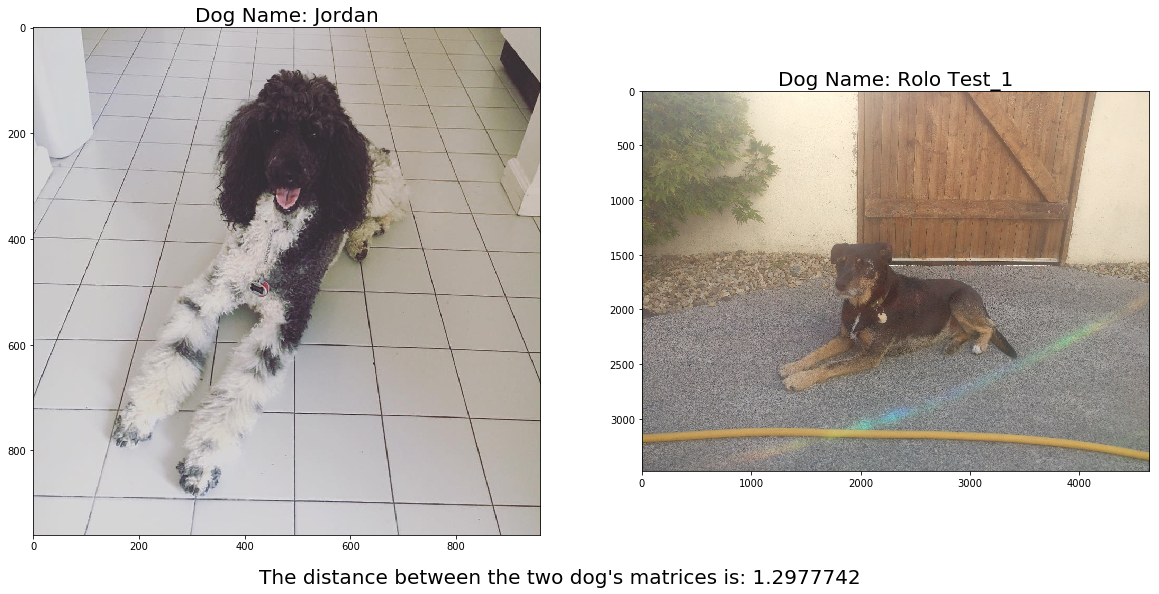

In [63]:
# jordan = plt.imread('images/jordan.jpg')
rolo1 = plt.imread('images/rolo1.jpg')

dist = np.linalg.norm( rolo1InterLayer - chelseaInterLayer)
dist

fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0),)
ax2 = plt.subplot2grid((1,2), (0,1),)
ax1.imshow(jordan)
ax1.set_title("Dog Name: Jordan",fontsize=20)
ax2.imshow(rolo1)
ax2.set_title("Dog Name: Rolo Test_1",fontsize=20)
plt.text(-3500,4500,"The distance between the two dog's matrices is: " + str(dist), fontsize=20)
plt.show()

In [91]:
dist = np.linalg.norm( rolo1InterLayer - chelseaInterLayer)
dist

17.613743

Comparison of rolo1 and predicted breed

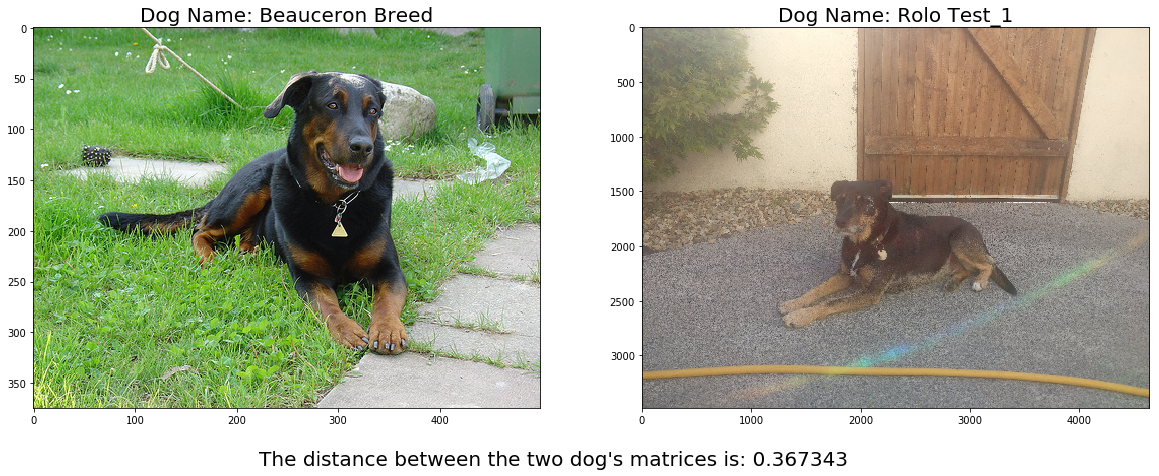

In [59]:
beauceron = plt.imread('dogImages/dogImages/test/018.Beauceron/Beauceron_01284.jpg')

dist = np.linalg.norm( rolo1InterLayer - testBeauceronInterLayer)
dist
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0),)
ax2 = plt.subplot2grid((1,2), (0,1),)
ax1.imshow(beauceron)
ax1.set_title("Dog Name: Beauceron Breed", fontsize=20)
ax2.imshow(rolo1)
ax2.set_title("Dog Name: Rolo Test_1", fontsize=20)
plt.text(-3500,4000,"The distance between the two dog's matrices is: " + str(dist), fontsize=20)
plt.show()

In [101]:
dist = np.linalg.norm( rolo1InterLayer - testBeauceronInterLayer)
dist

14.8595495

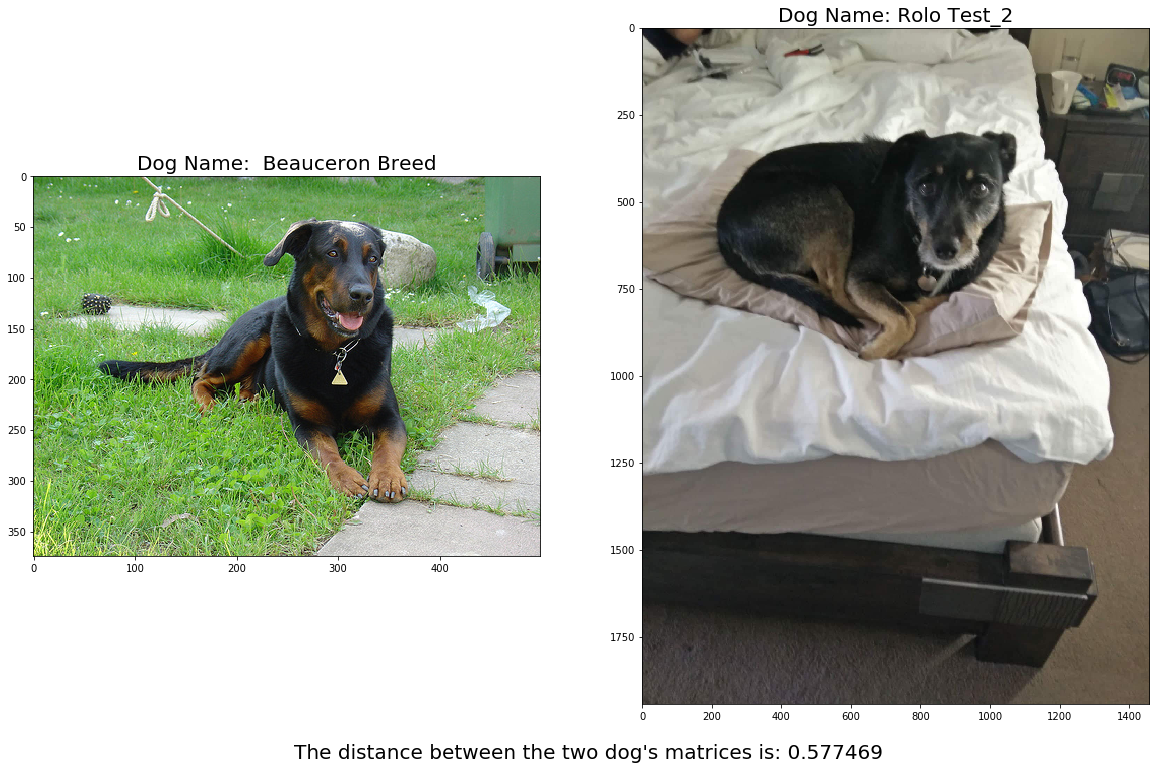

In [54]:
beauceron = plt.imread('dogImages/dogImages/test/018.Beauceron/Beauceron_01284.jpg')
dist = np.linalg.norm( rolo2InterLayer - testBeauceronInterLayer)
dist

fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0),)
ax2 = plt.subplot2grid((1,2), (0,1),)
ax1.imshow(beauceron)
ax1.set_title("Dog Name:  Beauceron Breed", fontsize=20)
ax2.imshow(rolo2)
ax2.set_title("Dog Name: Rolo Test_2", fontsize=20)
plt.text(-1000,2100,"The distance between the two dog's matrices is: " + str(dist), fontsize=20)
plt.show()

Converting Keras to Tensorflow

In [19]:
import tensorflow as tf

In [16]:
from keras.models import Model
from keras.layers import *
import os
import tensorflow as tf
def keras_to_tensorflow(keras_model, output_dir, model_name,out_prefix="output_", log_tensorboard=True):

    if os.path.exists(output_dir) == False:
        os.mkdir(output_dir)

    out_nodes = []

    for i in range(len(keras_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(keras_model.output[i], out_prefix + str(i + 1))

    sess = K.get_session()

    from tensorflow.python.framework import graph_util, graph_io

    init_graph = sess.graph.as_graph_def()

    main_graph = graph_util.convert_variables_to_constants(sess, init_graph, out_nodes)

    graph_io.write_graph(main_graph, output_dir, name=model_name, as_text=False)

    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard

        import_pb_to_tensorboard.import_to_tensorboard(
            os.path.join(output_dir, model_name),
            output_dir)

In [17]:
output_dir = os.path.join(os.getcwd(),"checkpoint")

keras_to_tensorflow(inception_model,output_dir=output_dir,model_name="doggieNet.pb")

print("MODEL SAVED")

INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.
Instructions for updating:
Use tf.gfile.GFile.
Model Imported. Visualize by running: tensorboard --logdir=C:\Users\Ciaran\Documents\CollegeOneDrive\Year 4\FYP\Development\Keras\dog-breed-classifier\checkpoint
MODEL SAVED


In [18]:
inception_model.save('doggie.h5') 

In [19]:
import tensorflow as tf
from tensorflow.python.platform import gfile
with tf.Session() as sess:
    model_filename ='checkpoint/doggieNet.pb'
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        g_in = tf.import_graph_def(graph_def)
LOGDIR='LOGS'
train_writer = tf.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)

In [43]:
path_to_frozen_graphdef_pb = "checkpoint/doggieNet.pb"
converter = lite.TFLiteConverter.from_frozen_graph(path_to_frozen_graphdef_pb, input_arrays, output_arrays)
tflite_model = converter.convert()
open("doggie.tflite", "wb").write(tflite_model)

NameError: name 'lite' is not defined

In [36]:
converter = tf.contrib.lite.TocoConverter.from_saved_model("checkpoint")
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

OSError: SavedModel file does not exist at: checkpoint/{saved_model.pbtxt|saved_model.pb}

In [38]:
with tf.Session() as sess:
    tflite_model = tf.contrib.lite.toco_convert(sess.graph_def, [img], [out])
    open("converteds_model.tflite", "wb").write(tflite_model)

NameError: name 'img' is not defined

In [56]:
from tensorflow.python.saved_model import tag_constants as _tag_constants
from tensorflow.python.saved_model import signature_constants as _signature_constants
from tensorflow.contrib.lite.python.convert_saved_model import freeze_saved_model as _freeze_saved_model
def from_saved_model(
                       saved_model_dir,
                       input_arrays=None,
                       input_shapes=None,
                       output_arrays=None,
                       tag_set=None,
                       signature_key=None):
    """Creates a TFLiteConverter class from a SavedModel.
    Args:
      saved_model_dir: SavedModel directory to convert.
      input_arrays: List of input tensors to freeze graph with. Uses input
        arrays from SignatureDef when none are provided. (default None)
      input_shapes: Dict of strings representing input tensor names to list of
        integers representing input shapes (e.g., {"foo" : [1, 16, 16, 3]}).
        Automatically determined when input shapes is None (e.g., {"foo" :
          None}). (default None)
      output_arrays: List of output tensors to freeze graph with. Uses output
        arrays from SignatureDef when none are provided. (default None)
      tag_set: Set of tags identifying the MetaGraphDef within the SavedModel to
        analyze. All tags in the tag set must be present. (default set("serve"))
      signature_key: Key identifying SignatureDef containing inputs and outputs.
        (default DEFAULT_SERVING_SIGNATURE_DEF_KEY)
    Returns:
      TFLiteConverter class.
    """
    if tag_set is None:
      tag_set = set([_tag_constants.SERVING])
    if signature_key is None:
      signature_key = _signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY

    result = _freeze_saved_model(saved_model_dir, input_arrays, input_shapes,
                                 output_arrays, tag_set, signature_key)
    return cls(
        graph_def=result[0], input_tensors=result[1], output_tensors=result[2])


In [60]:
path_to_frozen_graphdef_pb = "C:\\Users\\Ciaran\\Documents\\CollegeOneDrive\\Year 4\\FYP\\Development\\Keras\\dog-breed-classifier\\checkpoint\\"
converter = from_saved_model(path_to_frozen_graphdef_pb)
tflite_model = converter.convert()

OSError: SavedModel file does not exist at: C:\Users\Ciaran\Documents\CollegeOneDrive\Year 4\FYP\Development\Keras\dog-breed-classifier\checkpoint\/{saved_model.pbtxt|saved_model.pb}

In [104]:
from skimage.transform import rescale,resize

image = rolo1
image_resized = resize(image, (image.shape[0] / 4, image.shape[1] / 4),anti_aliasing=True)

c:\users\ciaran\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [107]:
plt.imsave("DSrolo.jpg",image_resized)

In [ ]:
DS = np.asarray(intermediateLayer('images/downSample.jpg'))

Loading image...
Extracting bottleneck features...


Saving model to .json format

In [22]:
model_json = inception_model.to_json()
with open("saved_models/model.json", "w") as json_file:
    json_file.write(model_json)

In [25]:
from ann_visualizer.visualize import ann_viz;
from keras.models import model_from_json
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
# load json and create model
json_file = open('saved_models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("doggie.h5")
ann_viz(model, title="Artificial Neural network - Model Visualization")

ValueError: invalid literal for int() with base 10: ''

Saving the model summary 

In [24]:
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        inception_model.summary()

Class activation maps

ValueError: Error when checking input: expected global_average_pooling2d_1_input to have 4 dimensions, but got array with shape (375, 500, 3)